# Custom mean functions: metalearning with GPs
One of the advantages of Gaussian process is their flexibility as a modeling tool. For instance, if the modeler knows that there is an underlying trend in the data, they can specify a mean function that captures this trend.

In this notebook, we illustrate how to use GPflow to construct a custom neural network mean function for GPs that can capture complex trends. We look at this functionality in the context of metalearning, where a number of metatasks are available at train time and the user wants to adapt a flexible model to new tasks at test time.

For an in-depth discussion on this topic, see *(Fortuin and Rätsch, 2019)*. This notebook reproduces section 4.2 of this paper.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models import GPR
from gpflow.base import Parameter

from gpflow.ci_utils import ci_niter

# for reproducibility of this notebook:
np.random.seed(1)
tf.random.set_seed(2)

%matplotlib inline

2022-03-07 11:40:14.023554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 11:40:14.023582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate the tasks
To generate the meta and test tasks, we sample from a Gaussian process with an Squared Exponential covariance function and a sinusoidal mean function. Each task is a realization of this process.

In [2]:
def generate_data(num_functions=10, N=500):
    """
    For each function, sample the value at `N` equally spaced
    points in the [−5, 5] interval (Fortuin and Rätsch, 2019).

    Returns:
        Tuple of np.arrays of size (N, 1) and (N, num_functions).
    """
    jitter = 1e-6
    Xs = np.linspace(-5.0, 5.0, N)[:, None]
    kernel = RBF(lengthscales=1.0)
    cov = kernel(Xs)
    L = np.linalg.cholesky(cov + np.eye(N) * jitter)
    epsilon = np.random.randn(N, num_functions)
    F = np.sin(Xs) + np.matmul(L, epsilon)
    return Xs, F

We generate 10 tasks for illustration.

In [3]:
Xs, F = generate_data(10)

2022-03-07 11:40:16.907027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 11:40:16.907056: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 11:40:16.907076: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b149603e3b87): /proc/driver/nvidia/version does not exist
2022-03-07 11:40:16.907351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


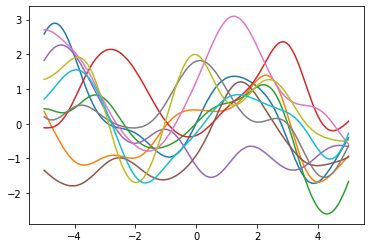

In [4]:
_ = plt.plot(Xs, F)

We generate the meta and test tasks.

In [5]:
def generate_meta_and_test_tasks(num_datapoints, num_meta, num_test, N):
    """Generates meta-task datasets {D_i} = {x_i, y_i} and target task training
    and test data {\tilde{x}, \tilde{y}} (Fortuin and Rätsch, 2019).

    Args:
        num_datapoints: The number of training points, \tilde{n} in Table S1.
        num_meta: The number of meta-tasks ("sampled functions").
        num_test: The number of test tasks ("unseen functions").
        N: Number of sampled data points per function.

    Returns:
        A tuple (meta, test) where
        - meta: List of num_meta pairs of arrays (X, Y) of size (n, 1) each.
        - test: List of num_test pairs of pairs of arrays of sizes
                (((num_datapoints, 1), (num_datapoints, 1)),
                 ((N - num_datapoints, 1), (N - num_datapoints, 1))).
    """
    Xs, F = generate_data(num_functions=num_meta + num_test, N=N)
    meta = []
    sd = 1e-1  # Standard deviation for normally-distributed observation noise.
    for i in range(num_meta):
        # We always use all data points of the curve to train the mean function,
        # i.e. n_i = N.
        noise = sd * np.random.randn(N, 1)
        Y = F[:, i][:, None] + noise
        meta.append((Xs, Y))
    test = []
    rand_indices = np.random.permutation(N)
    train_i = sorted(rand_indices[:num_datapoints])
    test_i = sorted(rand_indices[num_datapoints:])
    for i in range(num_test):
        # Form target training set, \tilde{D}_{train} (see Figure 1).
        noise = sd * np.random.randn(num_datapoints, 1)
        train_X = Xs[train_i]
        train_Y = F[train_i, num_meta + i][:, None] + noise
        # Form target test set, \tilde{D}_{test}, which is disjoint from the
        # target traininig set as it is in the original implementation.
        test_X = Xs[test_i]
        test_Y = F[test_i, num_meta + i][:, None]
        # Form target tasks' datasets \tilde{D} as a pair of pairs,
        # (\tilde{X}, \tilde{Y}) and (\tilde{X}*, \tilde{Y}*).
        test.append(((train_X, train_Y), (test_X, test_Y)))
    return meta, test

In [6]:
num_datapoints = 5
# Although the original experiment uses (1000, 200, 50) for the following
# parameters, we will use (50, 10, 500) for computational reasons.
num_meta_tasks = 50
num_test_tasks = 10
num_data_per_task = 500
meta, test = generate_meta_and_test_tasks(
    num_datapoints, num_meta_tasks, num_test_tasks, num_data_per_task
)

## Create the mean function
We will use a Keras model Deep Neural Network as mean function.

In [7]:
from gpflow.config import default_float


def build_mean_function():
    tf.keras.backend.set_floatx("float64")
    assert default_float() == np.float64

    inputs = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Dense(64, activation="relu")(inputs)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

## Build the GP metamodel
Metalearning boils down to learning a good prior that can generalize to new tasks with a small number of data points. This framework is prevalent in GP modeling, where we usually maximize the marginal likelihood to learn a good set of hyperparameters that specify the GP prior.

We perform the same optimization here, while sharing the hyperparameters across all the metatasks. For simplicity, we fix the kernel and likelihood parameters and learn those only for the mean function. Hence, our metalearning procedure is to cycle through the metatasks continuously, optimizing their marginal likelihood until a convergence criteria is reached (here, we just implement a fixed number of iterations over the tasks).

To begin this process, first we create a utility function that takes in a task (X, Y) and a mean function and outputs a GP model.

In [8]:
from gpflow import set_trainable


def build_model(data, mean_function):
    model = GPR(data, kernel=RBF(), mean_function=mean_function)
    set_trainable(model.kernel, False)
    model.likelihood.variance.assign(1e-2)
    set_trainable(model.likelihood, False)
    return model

In [9]:
def create_optimization_step(optimizer, model: gpflow.models.GPR):
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            objective = model.training_loss()
        grads = tape.gradient(objective, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return objective

    return optimization_step


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    adam = tf.optimizers.Adam()
    optimization_step = create_optimization_step(adam, model)
    for step in range(iterations):
        loss = optimization_step()
        if step % 10 == 0:
            # print("num variables", len(model.trainable_variables))
            logf.append(loss.numpy())
    return logf

Next, we define the training loop for metalearning.

In [10]:
import time


def train_loop(meta_tasks, num_iter=5):
    """
    Metalearning training loop. Trained for 100 epochs in original experiment.

    :param meta_tasks: list of metatasks.
    :param num_iter: number of iterations of tasks set
    :returns: a mean function object
    """
    # Initialize mean function
    mean_function = build_mean_function()
    # Iterate for several passes over the tasks set
    for iteration in range(num_iter):
        ts = time.time()
        print("Currently in meta-iteration/epoch {}".format(iteration))
        # Iterate over tasks
        for i, task in enumerate(meta_tasks):
            data = task  # (X, Y)
            model = build_model(data, mean_function=mean_function)
            run_adam(model, ci_niter(100))

        print(">>>> iteration took {:.2f} s".format(time.time() - ts))
    return mean_function


mean_function_optimal = train_loop(meta)

Currently in meta-iteration/epoch 0


2022-03-07 11:40:18.516822: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-03-07 11:40:19.900811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


>>>> iteration took 54.42 s
Currently in meta-iteration/epoch 1


>>>> iteration took 52.69 s
Currently in meta-iteration/epoch 2


>>>> iteration took 52.90 s
Currently in meta-iteration/epoch 3


>>>> iteration took 54.63 s
Currently in meta-iteration/epoch 4


>>>> iteration took 52.22 s


Finally, we use the optimized mean function for all of the test tasks. **NOTE:** We do not do any further optimization for the hyperparameters in this step.

In [11]:
test_models = [build_model(data, mean_function_optimal) for (data, _) in test]

## Assess the model
We assess the performance of this procedure on the test tasks. For this, we use the mean squared error as a performance metric.

In [12]:
def mean_squared_error(y, y_pred):
    return np.mean((y - y_pred) ** 2)

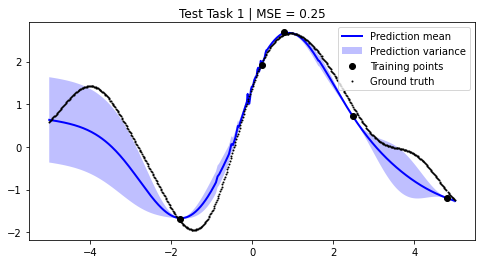

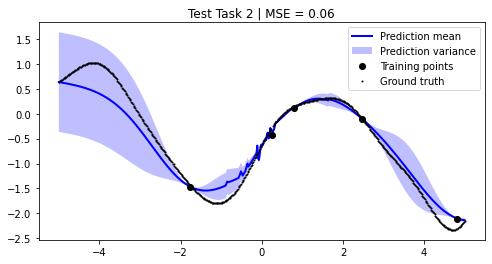

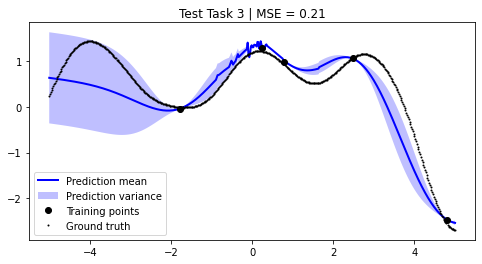

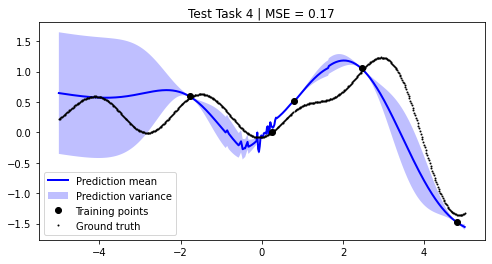

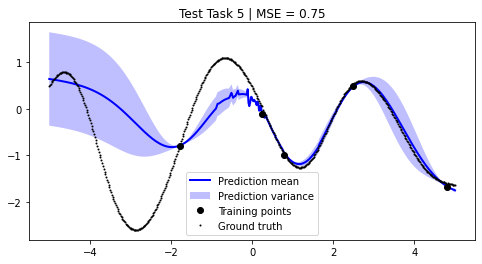

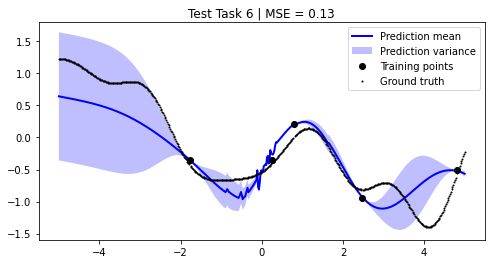

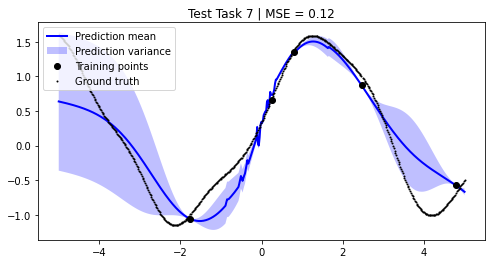

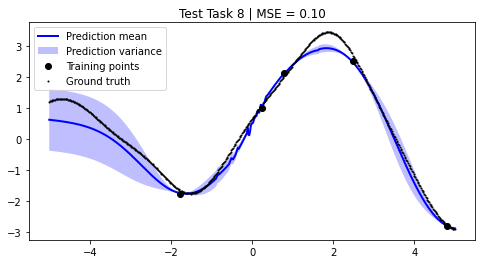

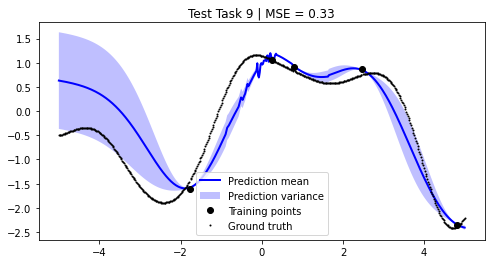

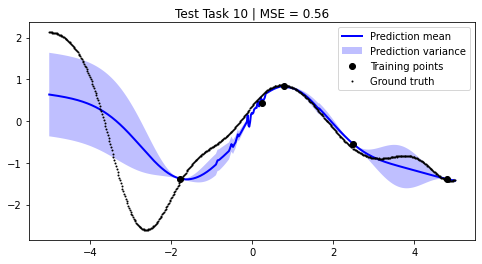

In [13]:
mean_squared_errors = []
for i, test_task in enumerate(test):
    plt.figure(figsize=(8, 4))
    (train_X, train_Y), (Xs, F) = test_task
    pred_mean, pred_var = test_models[i].predict_f(Xs)
    plt.plot(Xs, pred_mean, label="Prediction mean", color="blue", linewidth=2)
    plt.fill_between(
        Xs.squeeze(1),
        tf.squeeze(pred_mean - pred_var),
        tf.squeeze(pred_mean + pred_var),
        alpha=0.25,
        facecolor="blue",
        label="Prediction variance",
    )
    plt.plot(train_X, train_Y, "ko", label="Training points")
    plt.plot(Xs, F, "ko", label="Ground truth", linewidth=2, markersize=1)
    mse = mean_squared_error(F, pred_mean)
    mean_squared_errors.append(mse)
    plt.title(f"Test Task {i + 1} | MSE = {mse:.2f}")
    plt.legend()
    plt.show()

In [14]:
mean_mse = np.mean(mean_squared_errors)
std_mse = np.std(mean_squared_errors) / np.sqrt(num_test_tasks)
print(f"The mean MSE over all {num_test_tasks} test tasks is {mean_mse:.2f} +/- {std_mse:.2f}")

The mean MSE over all 10 test tasks is 0.27 +/- 0.07


We achieve comparable results to those reported in the paper.

**NOTE:** We use only 50 metatasks and 10 test tasks over 5 epochs for scalability, whereas the paper uses 1,000 and 200 respectively over 100 epochs. To compensate, we sample 500 points per curve, whereas the paper samples only 50 points. Hence, there might be some discrepancies in the results.

## References
Fortuin, Vincent, and Gunnar Rätsch. "Deep Mean Functions for Meta-Learning in Gaussian Processes." arXiv preprint arXiv:1901.08098 (2019).